In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/OD_project/raw/차량상태인식 (1).zip" /content

In [3]:
!unzip -q "/content/차량상태인식 (1).zip" -d /content/my_dataset

In [4]:
import os
import glob
import cv2
import shutil
import pandas as pd


def prepare_yolo_dataset_by_csv(root_path, csv_path, output_path):
    df = pd.read_csv(csv_path, encoding='utf-8-sig')
    df = df[['env', 'split']].dropna()
    df = df[df['split'].isin(['train', 'val', 'test'])]

    split_map = dict(zip(df['env'], df['split']))
    print(f"✅ CSV 로드 완료: {len(split_map)}개의 환경(env) 설정 읽음.")

    image_paths = glob.glob(os.path.join(root_path, "**/img/*.png"), recursive=True)
    print(f"총 {len(image_paths)}개의 이미지를 찾았습니다.")

    if len(image_paths) == 0:
        print("❌ 이미지를 찾지 못했습니다. root_path 확인 필요")
        return

    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_path, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_path, split, 'labels'), exist_ok=True)

    processed_count = 0
    missing_env_count = 0

    for img_path in image_paths:
        folder_name = img_path.split(os.sep)[-3]
        file_name = os.path.basename(img_path)

        target_split = split_map.get(folder_name)
        if not target_split:
            missing_env_count += 1
            continue

        new_base = f"{folder_name}_{file_name}"
        new_label = new_base.replace(".png", ".txt")

        org_label_path = img_path.replace("img", "new_txt").replace(".png", ".txt")
        if not os.path.exists(org_label_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w, _ = img.shape

        yolo_labels = []
        with open(org_label_path) as f:
            for line in f:
                data = list(map(float, line.split()))
                if len(data) < 5:
                    continue

                x1, y1, x2, y2 = data[:4]
                class_id = int(data[4])

                xc = ((x1 + x2) / 2) / w
                yc = ((y1 + y2) / 2) / h
                nw = (x2 - x1) / w
                nh = (y2 - y1) / h

                yolo_labels.append(
                    f"{class_id} {xc:.6f} {yc:.6f} {nw:.6f} {nh:.6f}"
                )

        if yolo_labels:
            shutil.copy(
                img_path,
                os.path.join(output_path, target_split, "images", new_base)
            )
            with open(
                os.path.join(output_path, target_split, "labels", new_label), "w"
            ) as f:
                f.write("\n".join(yolo_labels))

            processed_count += 1

    print("-" * 30)
    print("✨ 처리 완료!")
    print(f"- 성공적으로 변환된 이미지: {processed_count}장")
    print(f"- CSV에 정의되지 않아 제외된 폴더: {missing_env_count}개")
    print(f"- 결과 저장소: {os.path.abspath(output_path)}")

In [5]:
prepare_yolo_dataset_by_csv(
    root_path="/content/my_dataset",
    csv_path="/content/drive/MyDrive/OD_project/split_assignment.csv",
    output_path="/content/my_car_dataset"
)

✅ CSV 로드 완료: 165개의 환경(env) 설정 읽음.
총 42096개의 이미지를 찾았습니다.
------------------------------
✨ 처리 완료!
- 성공적으로 변환된 이미지: 33187장
- CSV에 정의되지 않아 제외된 폴더: 8909개
- 결과 저장소: /content/my_car_dataset


In [14]:
!pip install -U ultralytics

XXX

In [15]:
from ultralytics import YOLO
from pathlib import Path

DRIVE_SAVE_PATH = Path("/content/drive/MyDrive/OD_project")
#DRIVE_SAVE_PATH.mkdir(parents=True, exist_ok=True)

# 1. 모델 로드
model = YOLO(DRIVE_SAVE_PATH / "yolov11n_param_best.pt") # best.pt 넣기

# 2. 테스트 데이터 예측 (conf는 적절히 조절: 0.25 ~ 0.5)
# save_txt=True: YOLO 형식(.txt) 결과 저장
# save_conf=True: 나중에 필터링을 위해 점수도 저장하면 좋음
results = model.predict(
    source="/content/my_car_dataset/test/images",
    save_txt=True,
    conf=0.3,
    project="yolo_inference",
    name="test_results"
)
print("YOLO prediction done. Labels saved in yolo_inference/test_results/labels")

ImportError: cannot import name 'YOLO' from 'ultralytics' (/usr/local/lib/python3.12/dist-packages/ultralytics/__init__.py)

!!!

In [2]:
!pip install -U ultralytics # Ensure ultralytics is up-to-date

from ultralytics import YOLO
from pathlib import Path

DRIVE_SAVE_PATH = Path("/content/drive/MyDrive/OD_project")
#DRIVE_SAVE_PATH.mkdir(parents=True, exist_ok=True)

# 1. 모델 로드
model = YOLO(DRIVE_SAVE_PATH / "yolo11n_param_best.pt")

# 2. 테스트 데이터 예측 (conf는 적절히 조절: 0.25 ~ 0.5)
# save_txt=True: YOLO 형식(.txt) 결과 저장
# save_conf=True: 나중에 필터링을 위해 점수도 저장하면 좋음
results = model.predict(
    source="/content/my_car_dataset/test/images",
    save_txt=True,
    conf=0.4,
    project="yolo_inference",
    name="test_results_yolo11nparam",
    max_det=50,
    verbose=False,
    stream=True
)

for r in results:
  pass

print("YOLO prediction done. Labels saved in yolo_inference/test_results/labels")
# If ImportError persists after running this cell, please restart the Colab runtime (Runtime -> Restart runtime...).

Results saved to /content/yolo_inference/test_results_yolo11nparam
3712 labels saved to /content/yolo_inference/test_results_yolo11nparam/labels
YOLO prediction done. Labels saved in yolo_inference/test_results/labels


In [3]:
import os
import cv2
from pathlib import Path

def convert_yolo_to_resnet_format(yolo_label_dir, img_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    yolo_files = list(Path(yolo_label_dir).glob("*.txt"))

    print(f"Processing {len(yolo_files)} label files from {yolo_label_dir}...")

    for txt_file in yolo_files:
        # 1. 이미지 크기 확인 (비율 -> 픽셀 변환용)
        img_path = Path(img_dir) / f"{txt_file.stem}.png" # 확장자 주의
        if not img_path.exists():
            continue

        img = cv2.imread(str(img_path))
        if img is None:
             continue
        h, w, _ = img.shape

        new_lines = []
        with open(txt_file, "r") as f:
            for line in f:
                parts = line.split()
                cls = int(parts[0])
                cx, cy, nw, nh = map(float, parts[1:5])

                # 2. XYXY 픽셀 좌표로 변환
                x1 = (cx - nw/2) * w
                y1 = (cy - nh/2) * h
                x2 = (cx + nw/2) * w
                y2 = (cy + nh/2) * h

                # 3. 10개 컬럼 구성 (더미 라벨 0 포함)
                # x1 y1 x2 y2 cls loc a0 a1 a2 a3
                new_line = f"{x1:.2f} {y1:.2f} {x2:.2f} {y2:.2f} {cls} 0 0 0 0 0"
                new_lines.append(new_line)

        # 4. 분석용 파일 저장
        with open(Path(output_dir) / txt_file.name, "w") as f:
            f.write("\n".join(new_lines))
    print("Conversion completed.")

# 실행
# 주의: YOLO 결과 폴더가 test_results, test_results2 등으로 바뀔 수 있으니 확인 필요
convert_yolo_to_resnet_format(
    yolo_label_dir="yolo_inference/test_results_yolo11nparam/labels",
    img_dir="/content/my_car_dataset/test/images",
    output_dir="/content/my_car_dataset/test/new_txt"
)

Processing 3712 label files from yolo_inference/test_results_yolo11nparam/labels...
Conversion completed.


In [5]:
import pandas as pd
import torch
import os
from pathlib import Path
from tqdm import tqdm

def parse_split_to_csv_and_pt(split_name, envs, out_csv, out_pt):
    # 결과를 담을 리스트
    all_rows = []       # CSV용
    all_data_pt = []    # PT용 (모델 입력용)

    # 경로 수정: 실제 데이터가 있는 위치로 변경
    label_base_dir = Path("/content/my_car_dataset/test/new_txt")
    img_base_dir = Path("/content/my_car_dataset/test/images")

    print(f"--- {split_name} 데이터 통합 시작 ---")
    print(f"Labels dir: {label_base_dir}")
    print(f"Images dir: {img_base_dir}")

    # envs는 이미지 폴더 내의 하위 폴더 리스트입니다.
    for env in tqdm(envs):
        # 해당 환경(폴더) 내의 모든 텍스트 파일 탐색
        # 여기서는 단순히 label_base_dir 내의 모든 txt를 읽도록 되어 있음 (폴더 구조가 평탄화된 경우)
        txt_files = list(label_base_dir.glob("*.txt"))

        for txt_file in txt_files:
            img_path = img_base_dir / f"{txt_file.stem}.png" # 확장자 주의

            boxes_list = []
            if not txt_file.exists():
                 continue

            with open(txt_file, "r") as f:
                for line in f:
                    # x1 y1 x2 y2 cls loc a0 a1 a2 a3 (10개)
                    parts = list(map(float, line.split()))
                    if len(parts) < 10: continue

                    # 1. CSV용 데이터 추가
                    all_rows.append({
                        'frame_stem': txt_file.stem,
                        'env': env,
                        'x1': parts[0], 'y1': parts[1], 'x2': parts[2], 'y2': parts[3],
                        'class': int(parts[4]), 'location': int(parts[5]),
                        'a0': parts[6], 'a1': parts[7], 'a2': parts[8], 'a3': parts[9]
                    })

                    # 2. PT용 박스 리스트 추가
                    boxes_list.append(parts[:4]) # x1, y1, x2, y2 만 추출

            # PT 파일 구성을 위한 딕셔너리 생성
            if boxes_list:
                all_data_pt.append({
                    'image_path': str(img_path),
                    'env': env,
                    'boxes': torch.tensor(boxes_list, dtype=torch.float32),
                    'location': torch.zeros(len(boxes_list), dtype=torch.long), # 더미
                    'action': torch.zeros((len(boxes_list), 4), dtype=torch.float32) # 더미
                })

    # 결과 저장
    # 1. CSV 저장
    if all_rows:
        df = pd.DataFrame(all_rows)
        os.makedirs(os.path.dirname(out_csv), exist_ok=True)
        df.to_csv(out_csv, index=False)
        print(f"CSV Saved: {len(df)} rows")
    else:
        print("Warning: No data found for CSV.")

    # 2. PT 저장
    if all_data_pt:
        os.makedirs(os.path.dirname(out_pt), exist_ok=True)
        torch.save(all_data_pt, out_pt)
        print(f"PT Saved: {len(all_data_pt)} frames")
    else:
        print("Warning: No data found for PT.")

    print(f"\n✅ 완료!")
    print(f"파일 저장 위치: \n - {out_csv} \n - {out_pt}")

데이터 통합하기

In [6]:
import pandas as pd
import torch
import os
from pathlib import Path
from tqdm import tqdm

def parse_split_to_csv_and_pt(split_name, envs, out_csv, out_pt):
    all_rows = []
    all_data_pt = []

    # 베이스 경로 설정
    base_path = Path("/content/my_car_dataset/test")
    # 실제 환경에서는 이 경로가 존재하는지 먼저 확인하세요!
    if not base_path.exists():
        print(f"Error: 경로를 찾을 수 없습니다 -> {base_path}")
        return

    print(f"--- {split_name} 데이터 통합 시작 ---")

    for env in tqdm(envs):
        # 환경별로 label과 image 폴더가 나뉘어 있는 경우를 가정 (일반적인 구조)
        # 만약 txt 파일들이 한 폴더에 다 모여있다면 아래 경로를 수정해야 합니다.
        curr_label_dir = base_path / "new_txt"
        curr_img_dir = base_path / "images"

        # 현재 env 이름이 파일명에 포함되어 있거나, 하위 폴더인 경우 처리
        # 여기서는 파일명에 env가 포함되어 있지 않다면 glob("*.txt")로 모두 가져옵니다.
        txt_files = list(curr_label_dir.glob("*.txt"))

        if not txt_files:
            continue

        for txt_file in txt_files:
            # 1. 이미지 파일 존재 확인 (png, jpg 등 대응 가능하게 수정 권장)
            img_path = curr_img_dir / f"{txt_file.stem}.png"

            # 파일 내용 파싱
            boxes_list = []
            with open(txt_file, "r") as f:
                lines = f.readlines()
                if not lines: continue

                for line in lines:
                    parts = list(map(float, line.split()))
                    if len(parts) < 10: continue

                    # CSV 데이터 누적
                    all_rows.append({
                        'frame_stem': txt_file.stem,
                        'env': env,
                        'x1': parts[0], 'y1': parts[1], 'x2': parts[2], 'y2': parts[3],
                        'class': int(parts[4]), 'location': int(parts[5]),
                        'a0': parts[6], 'a1': parts[7], 'a2': parts[8], 'a3': parts[9]
                    })
                    boxes_list.append(parts[:4])

            # PT 데이터 누적
            if boxes_list:
                all_data_pt.append({
                    'image_path': str(img_path),
                    'env': env,
                    'boxes': torch.tensor(boxes_list, dtype=torch.float32),
                    'location': torch.zeros(len(boxes_list), dtype=torch.long),
                    'action': torch.zeros((len(boxes_list), 4), dtype=torch.float32)
                })

    # 결과 저장 로직 (이전과 동일)
    # 1. CSV 저장
    if all_rows:
        df = pd.DataFrame(all_rows)
        os.makedirs(os.path.dirname(out_csv), exist_ok=True)
        df.to_csv(out_csv, index=False)
        print(f"CSV Saved: {len(df)} rows")
    else:
        print("Warning: No data found for CSV.")

    # 2. PT 저장
    if all_data_pt:
        os.makedirs(os.path.dirname(out_pt), exist_ok=True)
        torch.save(all_data_pt, out_pt)
        print(f"PT Saved: {len(all_data_pt)} frames")
    else:
        print("Warning: No data found for PT.")

    print(f"\n✅ 완료!")
    print(f"파일 저장 위치: \n - {out_csv} \n - {out_pt}")

2

In [8]:
import pandas as pd
import torch
import os
from pathlib import Path
from tqdm import tqdm

def parse_split_to_csv_and_pt(split_name, envs, out_csv, out_pt):
    all_rows = []
    all_data_pt = []

    # 1. 베이스 경로 설정 및 존재 확인
    base_path = Path("/content/my_car_dataset/test")
    label_dir = base_path / "new_txt"
    img_dir = base_path / "images"

    if not label_dir.exists():
        print(f"❌ 에러: 라벨 폴더가 없습니다 -> {label_dir}")
        return

    # 2. 전체 텍스트 파일 목록 미리 가져오기
    # (envs 루프 밖에서 미리 가져와야 중복 실행을 막고 파일 존재 여부를 알 수 있습니다)
    all_txt_files = list(label_dir.glob("*.txt"))
    print(f"🔎 찾은 총 텍스트 파일 개수: {len(all_txt_files)}개")

    if len(all_txt_files) == 0:
        print("❌ 에러: .txt 파일이 하나도 없습니다. 경로를 다시 확인하세요.")
        return

    print(f"--- {split_name} 데이터 통합 시작 ---")

    # 3. 데이터 파싱
    # envs 필터링이 필요한 경우를 위해 루프 구성
    for env in envs:
        print(f"[{env}] 환경 처리 중...")

        # 만약 파일명에 env 이름이 포함되어야 하는 경우라면 아래처럼 필터링하세요.
        # 예: env가 'town01'이면 'town01_frame_001.txt' 등을 찾음
        target_files = [f for f in all_txt_files if env in f.name]

        # 만약 env와 상관없이 모든 파일을 읽어야 한다면 위 필터링을 주석 처리하고
        # target_files = all_txt_files 를 사용하세요.

        for txt_file in tqdm(target_files, desc=f"Processing {env}", leave=False):
            img_path = img_dir / f"{txt_file.stem}.png" # 확장자 주의 (.jpg 등)

            boxes_list = []
            with open(txt_file, "r") as f:
                for line in f:
                    parts = list(map(float, line.split()))
                    if len(parts) < 10: continue

                    all_rows.append({
                        'frame_stem': txt_file.stem,
                        'env': env,
                        'x1': parts[0], 'y1': parts[1], 'x2': parts[2], 'y2': parts[3],
                        'class': int(parts[4]), 'location': int(parts[5]),
                        'a0': parts[6], 'a1': parts[7], 'a2': parts[8], 'a3': parts[9]
                    })
                    boxes_list.append(parts[:4])

            if boxes_list:
                all_data_pt.append({
                    'image_path': str(img_path),
                    'env': env,
                    'boxes': torch.tensor(boxes_list, dtype=torch.float32),
                    'location': torch.zeros(len(boxes_list), dtype=torch.long),
                    'action': torch.zeros((len(boxes_list), 4), dtype=torch.float32)
                })

    # 4. 저장 및 최종 확인
    if all_rows:
        df = pd.DataFrame(all_rows)
        os.makedirs(os.path.dirname(out_csv), exist_ok=True)
        df.to_csv(out_csv, index=False)
        print(f"✅ CSV 저장 완료: {out_csv} ({len(df)}행)")
    else:
        print("⚠️ 경고: 저장할 CSV 데이터가 없습니다. (조건에 맞는 파일 없음)")

    if all_data_pt:
        os.makedirs(os.path.dirname(out_pt), exist_ok=True)
        torch.save(all_data_pt, out_pt)
        print(f"✅ PT 저장 완료: {out_pt} ({len(all_data_pt)}프레임)")
    else:
        print("⚠️ 경고: 저장할 PT 데이터가 없습니다.")

# 실행 예시 (envs에 아무것도 없으면 실행되지 않으므로 확인 필수!)
# parse_split_to_csv_and_pt("test", ["env_name_here"], "result.csv", "result.pt")

In [12]:
# 1. 환경 리스트 준비 (이미지 폴더 내 폴더들)
import os

# 수정: 실제 이미지가 존재하는 경로로 변경
test_img_path = "/content/my_car_dataset/test/images"

# 이미지 폴더 내부의 하위 폴더 리스트를 가져옵니다.
# 만약 하위 폴더가 없다면 ['default']라고 직접 넣어주세요.
if os.path.exists(test_img_path):
    test_envs = [d for d in os.listdir(test_img_path) if os.path.isdir(os.path.join(test_img_path, d))]
else:
    print(f"❌ 경로를 찾을 수 없습니다: {test_img_path}")
    test_envs = []

if not test_envs:
    test_envs = ['default']

print(f"Test Envs: {test_envs}")

# 2. 진짜로 함수 실행하기
# 앞서 정의한 parse_split_to_csv_and_pt 함수가 호출됩니다.
if 'parse_split_to_csv_and_pt' in globals():
    parse_split_to_csv_and_pt(
        split_name="test",
        envs=test_envs,
        out_csv="/content/roi_artifacts/test_yolo11nparam_bbox.csv",
        out_pt="/content/roi_artifacts/test_yolo11nparam_index.pt"
    )
else:
    print("⚠️ 'parse_split_to_csv_and_pt' 함수가 정의되지 않았습니다. 이전 셀을 실행해 주세요.")

Test Envs: ['default']
🔎 발견된 .txt 파일 개수: 3712개
--- test 데이터 통합 시작 ---


Processing files: 100%|██████████| 3712/3712 [00:00<00:00, 7416.98it/s]


✅ CSV 저장 완료: 25091 rows
✅ PT 저장 완료: 3712 frames


In [13]:
import pandas as pd
import os

# CSV 파일 경로
csv_path = "/content/roi_artifacts/test_yolo11nparam_bbox.csv"

if os.path.exists(csv_path) and os.path.getsize(csv_path) > 0:
    # 파일 읽기
    df = pd.read_csv(csv_path)

    print("=== [CSV 데이터 구조 확인] ===")
    print(f"전체 탐지된 객체(박스) 수: {len(df)}")
    print(f"컬럼 구성: {df.columns.tolist()}\n")

    # 데이터 상단 5개 출력
    print("=== [상단 5개 샘플 데이터] ===")
    display(df.head())
else:
    print(f"❌ CSV 파일이 없거나 비어 있습니다: {csv_path}")
    print("이전 셀(데이터 통합)이 정상적으로 완료되었는지 확인해 주세요.")

=== [CSV 데이터 구조 확인] ===
전체 탐지된 객체(박스) 수: 25091
컬럼 구성: ['frame_stem', 'env', 'x1', 'y1', 'x2', 'y2', 'class', 'location', 'a0', 'a1', 'a2', 'a3']

=== [상단 5개 샘플 데이터] ===


,frame_stem,env,x1,y1,x2,y2,class,location,a0,a1,a2,a3
0,OisamtoBanseok_Snow_00022104,default,883.07,218.31,1279.85,478.36,0,0,0.0,0.0,0.0,0.0
1,OisamtoBanseok_Snow_00022104,default,347.88,271.73,419.45,309.50,0,0,0.0,0.0,0.0,0.0
2,OisamtoBanseok_Snow_00022104,default,479.92,270.97,524.02,302.12,0,0,0.0,0.0,0.0,0.0
3,OisamtoBanseok_Snow_00022104,default,568.87,268.85,599.46,295.84,0,0,0.0,0.0,0.0,0.0
4,OisamtoBanseok_Snow_00022104,default,656.99,274.47,680.31,293.10,0,0,0.0,0.0,0.0,0.0


In [14]:
import torch

# .pt 파일 경로
pt_path = "/content/roi_artifacts/test_yolo11nparam_index.pt"

if os.path.exists(pt_path):
    data = torch.load(pt_path)
    print(f"=== [.pt 인덱스 파일 확인] ===")
    print(f"전체 프레임(이미지) 수: {len(data)}")

    # 첫 번째 프레임 정보 상세 출력
    sample = data[0]
    print("\n[첫 번째 샘플 상세 정보]")
    print(f"- 이미지 경로: {sample['image_path']}")
    print(f"- 환경(Env): {sample['env']}")
    print(f"- 박스 좌표(XYXY):\n{sample['boxes']}")
    print(f"- 장소 라벨(Location): {sample['location']}")
    print(f"- 행동 라벨(Action):\n{sample['action']}")

    # 텐서 모양(Shape) 확인
    print(f"\n- 박스 텐서 모양: {sample['boxes'].shape}") # [객체수, 4] 형태여야 함
else:
    print(".pt 파일이 아직 생성되지 않았습니다.")

=== [.pt 인덱스 파일 확인] ===
전체 프레임(이미지) 수: 3712

[첫 번째 샘플 상세 정보]
- 이미지 경로: /content/my_car_dataset/test/images/OisamtoBanseok_Snow_00022104.png
- 환경(Env): default
- 박스 좌표(XYXY):
tensor([[ 883.0700,  218.3100, 1279.8500,  478.3600],
        [ 347.8800,  271.7300,  419.4500,  309.5000],
        [ 479.9200,  270.9700,  524.0200,  302.1200],
        [ 568.8700,  268.8500,  599.4600,  295.8400],
        [ 656.9900,  274.4700,  680.3100,  293.1000],
        [ 533.4600,  274.7400,  552.7800,  289.7600],
        [ 543.3000,  274.8600,  561.1400,  287.8800],
        [ 598.1900,  273.1500,  616.4200,  286.7800]])
- 장소 라벨(Location): tensor([0, 0, 0, 0, 0, 0, 0, 0])
- 행동 라벨(Action):
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

- 박스 텐서 모양: torch.Size([8, 4])


시각화

이미지 확인 중: ETRINear_Fog_00001862
탐지된 박스 개수: 3


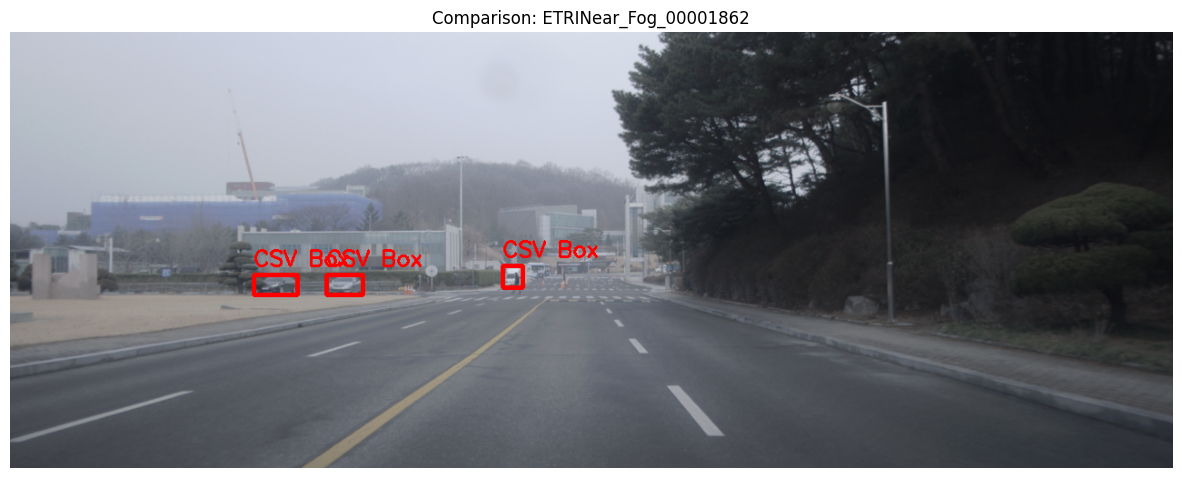

In [ ]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random

# 1. 경로 설정
img_base_dir = Path("/content/my_car_dataset/test/images")
csv_path = "/content/roi_artifacts/test_bbox.csv"

# 2. CSV 데이터 로드
df = pd.read_csv(csv_path)

# 3. 무작위로 이미지 하나 선택
random_stem = random.choice(df['frame_stem'].unique())
sample_df = df[df['frame_stem'] == random_stem]

# 4. 이미지 읽기
img_path = img_base_dir / f"{random_stem}.png"
image = cv2.imread(str(img_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
draw_img = image.copy()

print(f"이미지 확인 중: {random_stem}")
print(f"탐지된 박스 개수: {len(sample_df)}")

# 5. CSV에 저장된 픽셀 좌표로 박스 그리기 (빨간색)
for _, row in sample_df.iterrows():
    x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])

    # 박스 그리기
    cv2.rectangle(draw_img, (x1, y1), (x2, y2), (255, 0, 0), 3) # 빨간색
    cv2.putText(draw_img, f"CSV Box", (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# 6. 결과 출력
plt.figure(figsize=(15, 10))
plt.imshow(draw_img)
plt.title(f"Comparison: {random_stem}")
plt.axis('off')
plt.show()

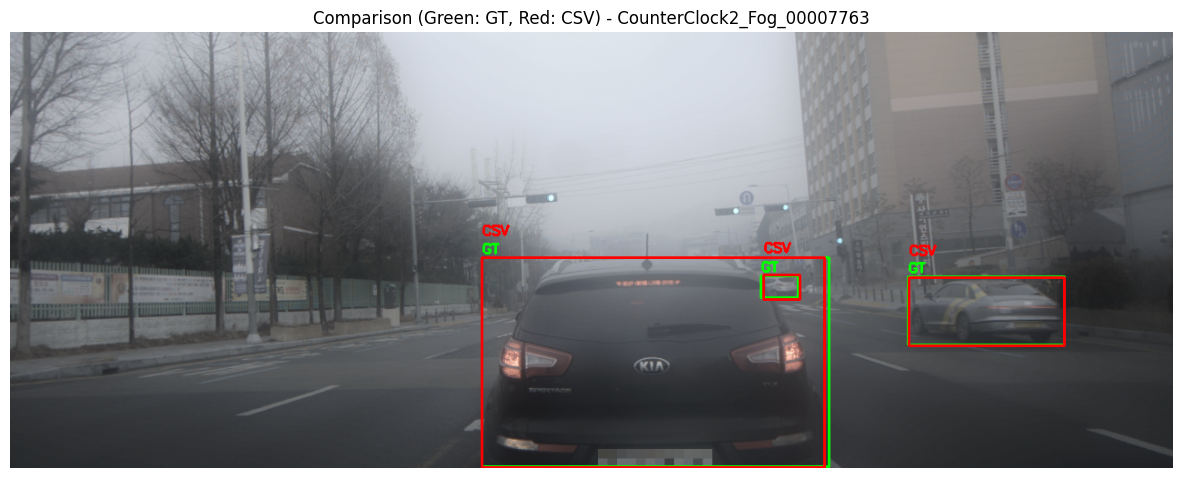

In [11]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random

# --- [경로 설정: 본인의 환경에 맞게 수정하세요] ---
img_base_dir = Path("/content/my_car_dataset/test/images")
csv_path = "/content/roi_artifacts/test_bbox.csv"
gt_label_dir = Path("/content/my_car_dataset/test/labels") # 원본 정답(GT) 텍스트 폴더

# 1. CSV 데이터 로드
# 파일이 없으면 오류가 발생하므로, 이전 셀(데이터 통합)이 정상적으로 완료되었는지 확인해 주세요.
df = pd.read_csv(csv_path)

# 2. 무작위 이미지 하나 선택 (CSV에 있는 파일 중 하나)
# Fix: Remove .png extension from target_file_name
target_file_name = "CounterClock2_Fog_00007763" # Changed from "CounterClock2_Fog_00007763.png"
random_stem = target_file_name
#random_stem = random.choice(df['frame_stem'].unique())
sample_df = df[df['frame_stem'] == random_stem]

# 3. 이미지 읽기
img_path = img_base_dir / f"{random_stem}.png"
image = cv2.imread(str(img_path))

# Check if image was loaded successfully before processing
if image is None:
    print(f"오류: 이미지를 로드할 수 없습니다. 경로를 확인하세요: {img_path}")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # --- 4. 원본 GT 박스 그리기 (초록색) ---
    gt_path = gt_label_dir / f"{random_stem}.txt"
    if gt_path.exists():
        with open(gt_path, 'r') as f:
            for line in f:
                parts = line.split()
                cls = parts[0]
                # YOLO 형식(cx, cy, nw, nh)을 픽셀 좌표로 변환
                cx, cy, nw, nh = map(float, parts[1:5])
                gx1 = int((cx - nw/2) * w)
                gy1 = int((cy - nh/2) * h)
                gx2 = int((cx + nw/2) * w)
                gy2 = int((cy + nh/2) * h)

                cv2.rectangle(image, (gx1, gy1), (gx2, gy2), (0, 255, 0), 2) # 초록색
                cv2.putText(image, "GT", (gx1, gy1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # --- 5. 내 CSV 박스 그리기 (빨간색) ---
    for _, row in sample_df.iterrows():
        x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])

        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2) # 빨간색
        cv2.putText(image, "CSV", (x1, y1 - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # 6. 결과 출력
    plt.figure(figsize=(15, 10))
    plt.imshow(image)
    plt.title(f"Comparison (Green: GT, Red: CSV) - {random_stem}")
    plt.axis('off')
    plt.show()

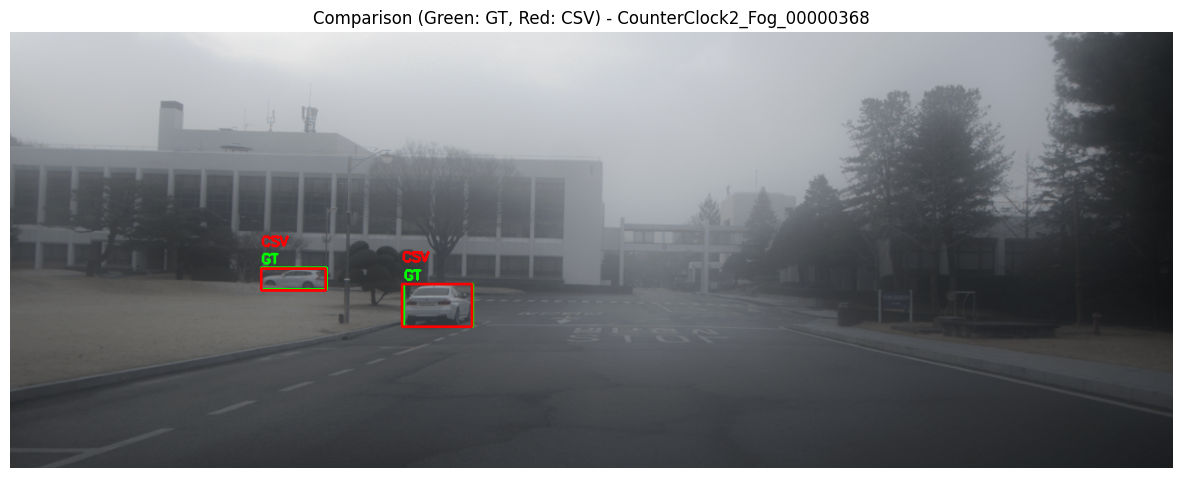

In [ ]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random

# --- [경로 설정: 본인의 환경에 맞게 수정하세요] ---
img_base_dir = Path("/content/my_car_dataset/test/images")
csv_path = "/content/roi_artifacts/test_bbox.csv"
gt_label_dir = Path("/content/my_car_dataset/test/labels") # 원본 정답(GT) 텍스트 폴더

# 1. CSV 데이터 로드
df = pd.read_csv(csv_path)

# 2. 무작위 이미지 하나 선택 (CSV에 있는 파일 중 하나)
target_file_name = "CounterClock2_Fog_00000368"
random_stem = target_file_name
#random_stem = random.choice(df['frame_stem'].unique())
sample_df = df[df['frame_stem'] == random_stem]

# 3. 이미지 읽기
img_path = img_base_dir / f"{random_stem}.png"
image = cv2.imread(str(img_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

# --- 4. 원본 GT 박스 그리기 (초록색) ---
gt_path = gt_label_dir / f"{random_stem}.txt"
if gt_path.exists():
    with open(gt_path, 'r') as f:
        for line in f:
            parts = line.split()
            cls = parts[0]
            # YOLO 형식(cx, cy, nw, nh)을 픽셀 좌표로 변환
            cx, cy, nw, nh = map(float, parts[1:5])
            gx1 = int((cx - nw/2) * w)
            gy1 = int((cy - nh/2) * h)
            gx2 = int((cx + nw/2) * w)
            gy2 = int((cy + nh/2) * h)

            cv2.rectangle(image, (gx1, gy1), (gx2, gy2), (0, 255, 0), 2) # 초록색
            cv2.putText(image, "GT", (gx1, gy1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# --- 5. 내 CSV 박스 그리기 (빨간색) ---
for _, row in sample_df.iterrows():
    x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])

    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2) # 빨간색
    cv2.putText(image, "CSV", (x1, y1 - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# 6. 결과 출력
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.title(f"Comparison (Green: GT, Red: CSV) - {random_stem}")
plt.axis('off')
plt.show()

In [ ]:
from ultralytics import YOLO

DRIVE_SAVE_PATH = Path("/content/drive/MyDrive/OD_project")
#DRIVE_SAVE_PATH.mkdir(parents=True, exist_ok=True)

# 1. 모델 로드
model = YOLO(DRIVE_SAVE_PATH / "yolov8nv1_best.pt")

# 2. 테스트 데이터 예측 (conf는 적절히 조절: 0.25 ~ 0.5)
# save_txt=True: YOLO 형식(.txt) 결과 저장
# save_conf=True: 나중에 필터링을 위해 점수도 저장하면 좋음
results = model.predict(
    source="/content/drive/MyDrive/OD_project/Capture",
    save_txt=True,
    conf=0.4,
    project="yolo_inference2",
    name="test_results",
    max_det=50,
    verbose=False,
    stream=True
)

for r in results:
  pass

print("YOLO prediction done. Labels saved in yolo_inference2/test_results/labels")

Results saved to /content/yolo_inference2/test_results
29 labels saved to /content/yolo_inference2/test_results/labels
YOLO prediction done. Labels saved in yolo_inference2/test_results/labels


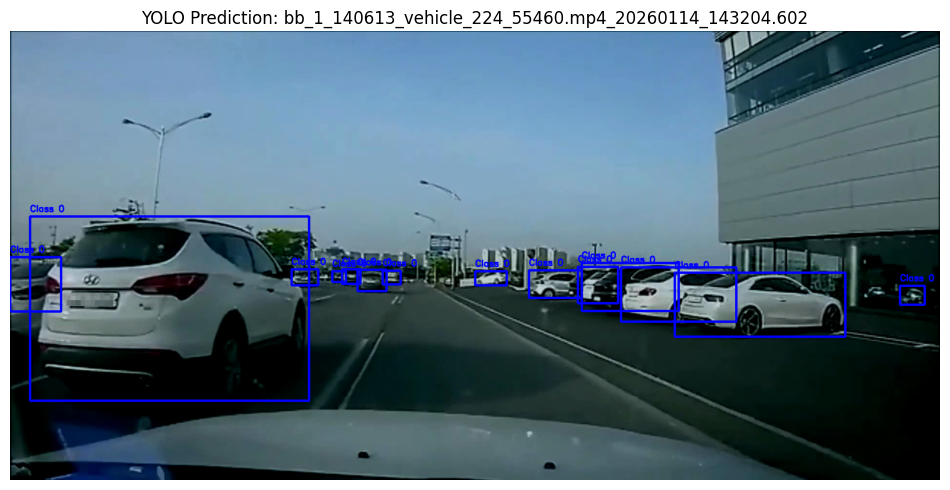

In [ ]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# --- [경로 설정] ---
img_dir = Path("/content/drive/MyDrive/OD_project/Capture")
label_dir = Path("yolo_inference2/test_results/labels")

# 확인하고 싶은 파일명 (확장자 제외)
target_file = "bb_1_140613_vehicle_224_55460.mp4_20260114_143204.602"

img_path = img_dir / f"{target_file}.png" # 또는 .jpg
label_path = label_dir / f"{target_file}.txt"

if not img_path.exists():
    print("이미지 파일을 찾을 수 없습니다.")
elif not label_path.exists():
    print("예측 결과(txt) 파일이 없습니다. (객체가 검출되지 않았을 수 있습니다)")
else:
    # 1. 이미지 로드
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # 2. TXT 파일 읽기 및 그리기
    with open(label_path, 'r') as f:
        for line in f:
            # YOLO txt 형식: class x_center y_center width height (confidence)
            parts = line.split()
            cls_id = parts[0]
            cx, cy, nw, nh = map(float, parts[1:5])

            # 픽셀 좌표로 복원
            #
            x1 = int((cx - nw / 2) * w)
            y1 = int((cy - nh / 2) * h)
            x2 = int((cx + nw / 2) * w)
            y2 = int((cy + nh / 2) * h)

            # 박스와 라벨 표시 (파란색)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)
            cv2.putText(image, f"Class {cls_id}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # 3. 결과 출력
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(f"YOLO Prediction: {target_file}")
    plt.axis('off')
    plt.show()